### Feathers in Focus: AML 2025 Kaggle Challenge 🪶
### Athina Papatriantafyllou • Alexandra Holíková • Buğra Sipahioğlu

### Setup Instructions
> **Setup Commands (in terminal):**
> ```bash
> python -m venv venv
> source venv/bin/activate
> pip install -r requirements.txt
> ```
> **Download the data and unzip it under "data/raw":** https://www.kaggle.com/competitions/aml-2025-feathers-in-focus/data

### Import the Libraries

In [1]:
# Import the libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from PIL import ImageStat
from sklearn.model_selection import train_test_split
from torchvision.io import decode_image
from torch.utils.data import Dataset
from torchvision.transforms import v2
import torch
from torch.utils.data import DataLoader

### Define the constants (So that it's easier to change some of them.)

In [2]:
# Data path constants 
DATA_DIR = "../data/raw"
TRAIN_CSV_PATH = f"{DATA_DIR}/train_images.csv"
TEST_CSV_PATH = f"{DATA_DIR}/test_images_path.csv"
CLASS_NAMES_PATH = f"{DATA_DIR}/class_names.npy"
ATTRIBUTES_PATH = f"{DATA_DIR}/attributes.npy"
ATTRIBUTES_TXT_PATH = f"{DATA_DIR}/attributes.txt"
TRAIN_IMAGES_BASE_PATH = f"{DATA_DIR}/train_images"
TEST_IMAGES_BASE_PATH = f"{DATA_DIR}/test_images"

# Dataset constants
VAL_SPLIT_RATIO = 0.2  # 20% validation 80% test for instance. 
RANDOM_STATE = 45  # Keep the same random state across runs for reproducibility
NUM_CLASSES = 200 # It's given in the Kaggle competition description, so we don't need to count it (yet it's counted in EDA part)

# Image transformation constants
IMAGE_SIZE = 224  # Final image size after transformations
RESIZE_SIZE = 256  # Size before center crop for validation/test
RANDOM_CROP_SCALE = (0.7, 1.0)  # RandomResizedCrop scale range
HORIZONTAL_FLIP_PROB = 0.5  # RandomHorizontalFlip probability
ROTATION_DEGREES = 15  # RandomRotation degrees
COLOR_JITTER_BRIGHTNESS = 0.2
COLOR_JITTER_CONTRAST = 0.25
COLOR_JITTER_SATURATION = 0.25
COLOR_JITTER_HUE = 0.15

# Normalization constants (ImageNet normalization statistics since pretrained models are usually trained on ImageNet)
NORMALIZE_MEAN = [0.485, 0.456, 0.406]
NORMALIZE_STD = [0.229, 0.224, 0.225]

# Device constants
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'mps' if torch.backends.mps.is_available() else 'cpu')
BATCH_SIZE_CPU = 16
BATCH_SIZE_GPU = 32
BATCH_SIZE_MPS = 32
NUM_WORKERS_CPU = 0
NUM_WORKERS_GPU = 0
NUM_WORKERS_MPS = 0
PIN_MEMORY_CPU = False
PIN_MEMORY_GPU = True
PIN_MEMORY_MPS = False

### Load the data

In [3]:
# Load the training and test sets
train_df = pd.read_csv(TRAIN_CSV_PATH)
test_df = pd.read_csv(TEST_CSV_PATH)
class_names = np.load(CLASS_NAMES_PATH, allow_pickle=True).item()

# Load attributes
attributes = np.load(ATTRIBUTES_PATH, allow_pickle=True)
with open(ATTRIBUTES_TXT_PATH, "r") as f:
    attribute_names = [line.strip().split(' ', 1)[1] for line in f.readlines()]

# Print the data summary
print("Loading the data....")
print(f"-Train Size: {len(train_df)} \n-Test Size: {len(test_df)} \n-Number of Classes: {len(class_names)}")
print(f"-Attributes: {len(attribute_names)} (shape: {attributes.shape if hasattr(attributes, 'shape') else 'N/A'})")


Loading the data....
-Train Size: 3926 
-Test Size: 4000 
-Number of Classes: 200
-Attributes: 312 (shape: (200, 312))


### Explore the data

Random images (with their labels)from the training set:


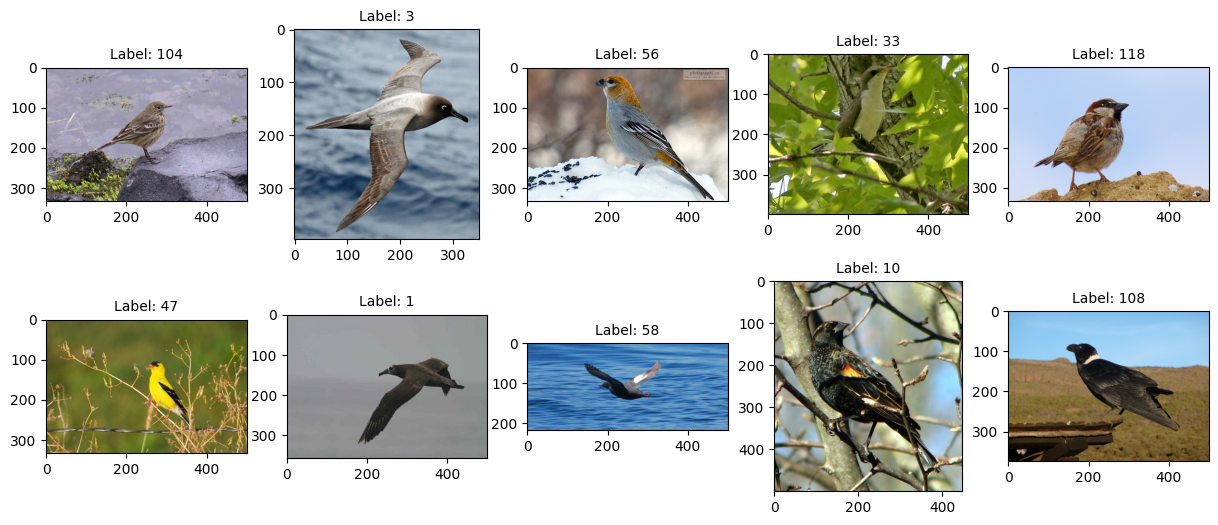

In [4]:
# Inspect the training set by showing 10 random images
print("Random images (with their labels)from the training set:")
samples = train_df.sample(10)
fig, axes = plt.subplots(2, 5, figsize=(15, 6))
for ax, (_, row) in zip(axes.flat, samples.iterrows()):
    img = Image.open(f"{TRAIN_IMAGES_BASE_PATH}{row['image_path']}")
    label_name = class_names.get(row['label'], f"Label: {row['label']}")
    ax.set_title(label_name, fontsize=10)
    ax.imshow(img)
plt.show()

Checking 3926 images' dimensions: 
-Width: min=140, max=500, mean=467.78
-Height: min=120, max=500, mean=385.37


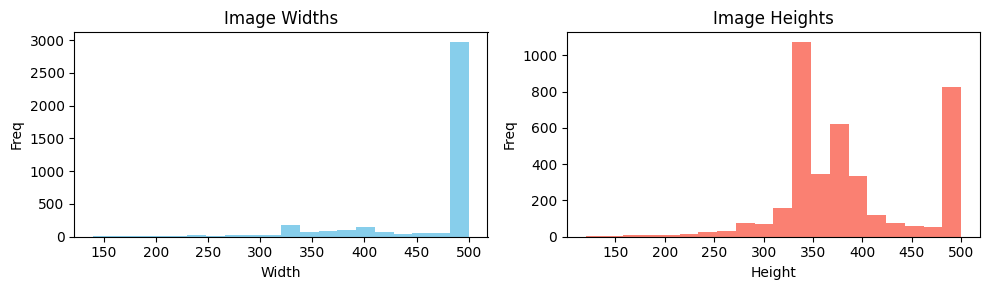

In [5]:
# Check image dimensions in the training set (concise version)
sizes = []
for p in train_df['image_path']:
    sizes.append(Image.open(f"{TRAIN_IMAGES_BASE_PATH}{p}").size)
widths = [s[0] for s in sizes]
heights = [s[1] for s in sizes]
print(f"Checking {len(widths)} images' dimensions: \n-Width: min={min(widths)}, max={max(widths)}, mean={np.mean(widths):.2f}\n-Height: min={min(heights)}, max={max(heights)}, mean={np.mean(heights):.2f}")

fig, axs = plt.subplots(1,2,figsize=(10,3))
axs[0].hist(widths, bins=20, color='skyblue'), axs[0].set(title='Image Widths', xlabel='Width', ylabel='Freq')
axs[1].hist(heights, bins=20, color='salmon'), axs[1].set(title='Image Heights', xlabel='Height', ylabel='Freq')
plt.tight_layout()
plt.show()

In [6]:
# Inspect the attributes
attributes_df = pd.DataFrame({'Index': range(len(attribute_names)), 'Attribute Name': attribute_names})
print("Attributes:")
display(attributes_df.head(10))

Attributes:


,Index,Attribute Name
0,0,has_bill_shape::curved_(up_or_down)
1,1,has_bill_shape::dagger
2,2,has_bill_shape::hooked
3,3,has_bill_shape::needle
4,4,has_bill_shape::hooked_seabird
5,5,has_bill_shape::spatulate
6,6,has_bill_shape::all-purpose
7,7,has_bill_shape::cone
8,8,has_bill_shape::specialized
9,9,has_wing_color::blue


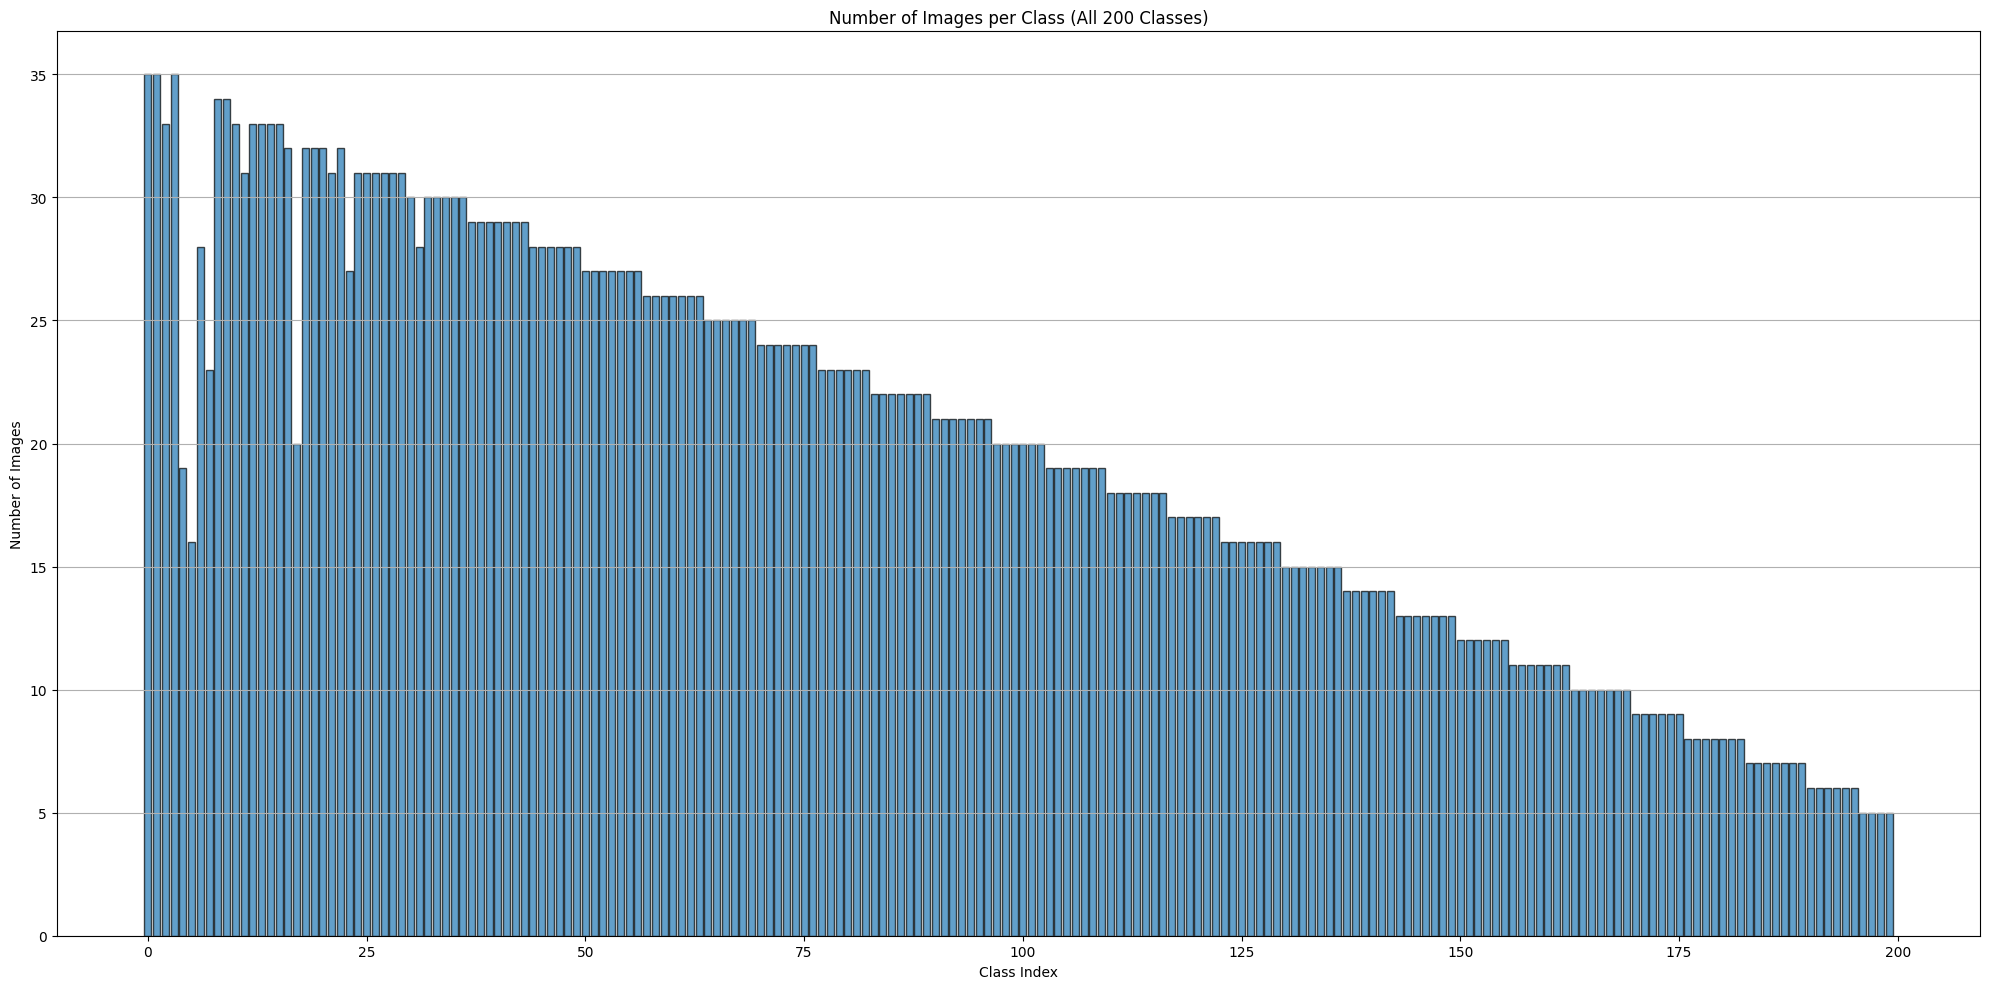

Statistics:
-Number of unique classes: 200
-Average number of images per class: 19.63
-Standard deviation of images per class: 8.39 (Lower the std, more balanced the dataset)
-Minimum number of images per class: 5
-Maximum number of images per class: 35


In [7]:
# Plot the class distribution to inspect the balance
class_counts = train_df['label'].value_counts().sort_index()
fig, ax = plt.subplots(figsize=(20, 10))

# Show the count for each class
ax.bar(range(len(class_counts)), class_counts.values, tick_label=None, edgecolor='k', alpha=0.7)
ax.set_xlabel('Class Index')
ax.set_ylabel('Number of Images')
ax.set_title('Number of Images per Class (All 200 Classes)')
ax.grid(axis='y')
plt.tight_layout()
plt.show()

# Statistics
print("Statistics:")
print(f"-Number of unique classes: {len(class_names)}")
print(f"-Average number of images per class: {class_counts.mean():.2f}")
print(f"-Standard deviation of images per class: {class_counts.std():.2f} (Lower the std, more balanced the dataset)")
print(f"-Minimum number of images per class: {class_counts.min()}")
print(f"-Maximum number of images per class: {class_counts.max()}")


In [8]:
# Check for Corrupted Images

# Check Training Set
corrupt_counter_train = 0
for idx, row in train_df.iterrows():
    img_path = f"{TRAIN_IMAGES_BASE_PATH}{row['image_path']}"
    try:
        img = Image.open(img_path)
        img.verify()
    except Exception:
        corrupt_counter_train += 1

# Check Test Set
corrupt_counter_test = 0
for idx, row in test_df.iterrows():
    img_path = f"{TEST_IMAGES_BASE_PATH}{row['image_path']}"
    try:
        img = Image.open(img_path)
        img.verify()
    except Exception:
        corrupt_counter_test += 1

# Print the results
print(f"Total corrupt images in training set: {corrupt_counter_train}")
print(f"Total corrupt images in test set: {corrupt_counter_test}")


Total corrupt images in training set: 0
Total corrupt images in test set: 0


In [9]:
# Check the color stats for all training images
def get_color_stats(image_path):
    img = Image.open(image_path).convert('RGB')
    stat = ImageStat.Stat(img)
    brightness = sum(stat.mean) / len(stat.mean)
    contrast = sum(stat.stddev) / len(stat.stddev)
    saturation = max(stat.mean) - min(stat.mean)
    return brightness, contrast, saturation

stats = [get_color_stats(f"{TRAIN_IMAGES_BASE_PATH}{p}") for p in train_df['image_path']]
brightnesses = [s[0] for s in stats]
contrasts = [s[1] for s in stats]
saturations = [s[2] for s in stats]

print(f"Color Statistics:")
print(f"- Brightness: mean={np.mean(brightnesses):.2f}, std={np.std(brightnesses):.2f}, range=[{min(brightnesses):.2f}, {max(brightnesses):.2f}]")
print(f"- Contrast: mean={np.mean(contrasts):.2f}, std={np.std(contrasts):.2f}, range=[{min(contrasts):.2f}, {max(contrasts):.2f}]")
print(f"- Saturation: mean={np.mean(saturations):.2f}, std={np.std(saturations):.2f}, range=[{min(saturations):.2f}, {max(saturations):.2f}]")
print("\nWISE WORDS FROM THE ML GODS:")
print("- High variance values indicate that our images already have diverse properties.\n- Hence, we don't need to use (high parameters for) ColorJitter.")

Color Statistics:
- Brightness: mean=121.81, std=33.72, range=[18.69, 244.95]
- Contrast: mean=47.22, std=14.21, range=[11.51, 106.21]
- Saturation: mean=32.34, std=25.01, range=[0.00, 178.80]

WISE WORDS FROM THE ML GODS:
- High variance values indicate that our images already have diverse properties.
- Hence, we don't need to use (high parameters for) ColorJitter.


### Split the data into training, validation and test sets

In [10]:
# Extract image paths and labels
X = train_df['image_path'].values
y = train_df['label'].values       

# Look at indices of labels (Y)
print("Before correction:")
print("- y indices min:", y.min())
print("- y indices max:", y.max())

# Since the labels start from 1, convert them to 0-indexed
y = y - 1

print("After correction:")
print("- y indices min:", y.min())
print("- y indices max:", y.max())

# Split the data into training and validation sets (80% train, 20% validation)
X_test = test_df['image_path'].values
X_train, X_val, y_train, y_val = train_test_split(
    X, y, 
    test_size = VAL_SPLIT_RATIO, 
    random_state = RANDOM_STATE, # keep the same random state across runs for reproducibility
    stratify = y  # Maintains class distribution in both sets
)

Before correction:
- y indices min: 1
- y indices max: 200
After correction:
- y indices min: 0
- y indices max: 199


### Define the transformations

In [11]:
# Transformations for training set
transformation_training = v2.Compose([

    # Randomly crop to IMAGE_SIZE from a resized area of the image.
    # - Scale controls how much of the original image area we keep (tunable via RANDOM_CROP_SCALE).
    # - Since feathers require fine details, we keep the scale high.
    # - Antialias=True is used to improve the quality of the resized image.
    v2.RandomResizedCrop(size=(IMAGE_SIZE, IMAGE_SIZE), scale=RANDOM_CROP_SCALE, antialias=True),
    
    # Random horizontal flip (tunable via HORIZONTAL_FLIP_PROB)
    v2.RandomHorizontalFlip(p=HORIZONTAL_FLIP_PROB), 
    
    # Random rotation (tunable via ROTATION_DEGREES)
    v2.RandomRotation(degrees=ROTATION_DEGREES), 
    
    # Color jitter (tunable via COLOR_JITTER constants)
    # Kept small since the stats of the training images are already diverse.
    # Strong color augmentations can distort the images and make the model more confused.
    v2.ColorJitter(
        brightness=COLOR_JITTER_BRIGHTNESS, 
        contrast=COLOR_JITTER_CONTRAST, 
        saturation=COLOR_JITTER_SATURATION, 
        hue=COLOR_JITTER_HUE
    ), 
    
    # Convert to float32 and scale to [0,1] (also converts to tensor)
    v2.ToDtype(torch.float32, scale=True),
    
    # Normalize the image (ImageNet stats for pretrained models, tunable)
    v2.Normalize(mean=NORMALIZE_MEAN, std=NORMALIZE_STD), 
])

# Transformations for validation set
transformation_validation = v2.Compose([
    
    # Resize to RESIZE_SIZE (no randomness for consistent validation)
    v2.Resize(RESIZE_SIZE, antialias=True),

    # Center crop to IMAGE_SIZE (matches the training set)
    v2.CenterCrop(IMAGE_SIZE),
    
    # Convert to float32 and scale to [0,1] (also converts to tensor)
    v2.ToDtype(torch.float32, scale=True),
     
    # Normalize the image (must match the training normalization)
    v2.Normalize(mean=NORMALIZE_MEAN, std=NORMALIZE_STD)
])

### Create Custom Dataset for PyTorch

In [12]:
# Pytorch needs a custom dataset to load and transform the data
class FeatherImageDataset(Dataset):
    def __init__(self, image_paths, image_labels, transformation=None, target_transformation=None):
        self.image_paths = image_paths
        self.image_labels = image_labels
        self.transformation = transformation
        self.target_transformation = target_transformation
    
    def __len__(self):
        return len(self.image_labels)
    
    def __getitem__(self, i):
        image_path = self.image_paths[i]
        image_label = self.image_labels[i]  
        image = decode_image(image_path)
        if self.transformation:
            image = self.transformation(image)
        if self.target_transformation:
            image_label = self.target_transformation(image_label)
        return image, image_label

### Create Dataset Instances and DataLoaders

In [13]:
# Create dataset instances with transformations
# Create custom dataset instance for training set
train_dataset = FeatherImageDataset(
    image_paths = [TRAIN_IMAGES_BASE_PATH + path for path in X_train],
    image_labels = y_train,
    transformation = transformation_training
)

# Create custom dataset instance for validation set
val_dataset = FeatherImageDataset(
    image_paths = [TRAIN_IMAGES_BASE_PATH + path for path in X_val],
    image_labels = y_val,
    transformation = transformation_validation
)

# Check device availability
# - If GPU is available, use it
# - If MPS is available, use it (GPU supportfor Apple Silicon)
# - Otherwise, use CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'mps' if torch.backends.mps.is_available() else 'cpu')
if device.type == 'cuda':
    batch_size = BATCH_SIZE_GPU
    num_workers = NUM_WORKERS_GPU # Set to 0 for Jupyter notebooks as they might fail with too many workers
    pin_memory = PIN_MEMORY_GPU  # FYI: Pin memory speeds up the transfer data from CPU RAM to GPU vRAM
elif device.type == 'mps':
    batch_size = BATCH_SIZE_MPS
    num_workers = NUM_WORKERS_MPS
    pin_memory = PIN_MEMORY_MPS  # MPS doesn't support pin_memory
else:
    batch_size = BATCH_SIZE_CPU
    num_workers = NUM_WORKERS_CPU
    pin_memory = PIN_MEMORY_CPU  # Not needed for CPU (since it's used to speed up the transfer data from CPU RAM to GPU vRAM)

# Print the DataLoader configuration
print("DataLoader configuration:")
print(f"- Using device: {device}")
print(f"- Batch size: {batch_size}")
print(f"- Number of workers: {num_workers} (0 = main process, avoids pickling issues in Jupyter)")
print(f"- Pin memory: {pin_memory}")

# Create DataLoader for training set
train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,  # Shuffle training data so that the model doesn't memorize the order of the data
    num_workers=num_workers,
    pin_memory=pin_memory
)

# Create DataLoader for validation set
val_loader = DataLoader(
    val_dataset,
    batch_size=batch_size,
    shuffle=False,  # Don't shuffle validation data: So that each time we use the validation, it's the same
    num_workers=num_workers,
    pin_memory=pin_memory  
)

# Print the final information
print(f"\nSetup:")
print(f"- Train dataset: {len(train_dataset)} samples")
print(f"- Validation dataset: {len(val_dataset)} samples")
print(f"- Batch size: {batch_size}")

DataLoader configuration:
- Using device: mps
- Batch size: 32
- Number of workers: 0 (0 = main process, avoids pickling issues in Jupyter)
- Pin memory: False

Setup:
- Train dataset: 3140 samples
- Validation dataset: 786 samples
- Batch size: 32


### Model Training (You can check the sample demonstration for how to use train_loader and val_loader)

### Pretrained Model for Baseline

Saw this somewhere and implemented it \
Not sure yet if we will keep it \
No need to look at it now

In [25]:
import torch
import torch.nn as nn
from torchvision.models import resnet50, ResNet50_Weights

# Load pre-trained ResNet50
#model = resnet50(pretrained=True)
model = resnet50(weights=ResNet50_Weights.IMAGENET1K_V2)
model.fc = nn.Linear(model.fc.in_features, 200)  # 200 bird species

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /Users/alexandraholikova/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth


URLError: <urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: unable to get local issuer certificate (_ssl.c:1000)>

In [20]:
import torch.optim as optim

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

Train the model

In [21]:
epochs = 10

for epoch in range(epochs):
    model.train()
    running_loss = 0.0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f"Epoch {epoch+1}/{epochs}, Loss: {running_loss/len(train_loader)}")

RuntimeError: Input type (MPSFloatType) and weight type (torch.FloatTensor) should be the same

Validate the model

In [ ]:
def validate(model, val_loader, criterion=None):
    model.eval()
    correct, total = 0, 0
    val_loss = 0.0 if criterion else None

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            _, predicted = torch.max(outputs, 1)

            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            if criterion: # If loss function is defined
                loss = criterion(outputs, labels)
                val_loss += loss.item()

    acc = correct / total # Calculate accuracy over entire validation set

    if criterion:
        return acc, val_loss / len(val_loader) # Average loss per batch
    return acc


val_acc, val_loss = validate(model, val_loader, criterion)  # Gets both values
print(f"Results: Val Acc: {val_acc:.3f} ({val_acc*100:.1f}%), Val Loss: {val_loss:.4f}")

### Hugging face for Baseline

In [26]:
# Use a pipeline as a high-level helper
from transformers import pipeline

pipe = pipeline("image-classification", model="Emiel/cub-200-bird-classifier-swin")
pipe("https://huggingface.co/datasets/huggingface/documentation-images/resolve/main/hub/parrots.png")

Device set to use mps:0


[{'label': 'Pacific_Loon', 'score': 0.045932356268167496},
 {'label': 'Ovenbird', 'score': 0.02930556796491146},
 {'label': 'Hooded_Oriole', 'score': 0.029163602739572525},
 {'label': 'Black_Tern', 'score': 0.0259512010961771},
 {'label': 'Rufous_Hummingbird', 'score': 0.023637680336833}]

In [27]:
# Load model directly
from transformers import AutoImageProcessor, AutoModelForImageClassification

processor = AutoImageProcessor.from_pretrained("Emiel/cub-200-bird-classifier-swin")
model = AutoModelForImageClassification.from_pretrained("Emiel/cub-200-bird-classifier-swin")

In [28]:
class FeatherImageDatasetHF(Dataset):
    def __init__(self, image_paths, image_labels=None, processor=None):
        self.image_paths = image_paths
        self.image_labels = image_labels
        self.processor = processor

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, i):
        image = decode_image(self.image_paths[i])
        inputs = self.processor(images=image, return_tensors="pt")
        inputs = {k: v.squeeze(0) for k, v in inputs.items()}

        # Add labels only for train/val
        if self.image_labels is not None:
            inputs["labels"] = torch.tensor(self.image_labels[i], dtype=torch.long)
        
        return inputs


In [29]:
def validate_hf(model, val_loader, device):
    model.eval()
    correct, total = 0, 0

    with torch.no_grad():
        for batch in val_loader:
            # Move all inputs to device
            batch = {k: v.to(device) for k, v in batch.items()}
            labels = batch.pop("labels")  # remove labels
            
            outputs = model(**batch)
            preds = outputs.logits.argmax(dim=1)

            total += labels.size(0)
            correct += (preds == labels).sum().item()

    return correct / total


In [30]:
train_dataset_hf = FeatherImageDatasetHF(
    [TRAIN_IMAGES_BASE_PATH + path for path in X_train],
    y_train,
    processor
)

val_dataset_hf = FeatherImageDatasetHF(
    [TRAIN_IMAGES_BASE_PATH + path for path in X_val],
    y_val,
    processor
)

train_loader_hf = DataLoader(train_dataset_hf, batch_size=batch_size, shuffle=True, 
                             num_workers=num_workers, pin_memory=pin_memory)

val_loader_hf = DataLoader(val_dataset_hf, batch_size=batch_size, shuffle=False, 
                           num_workers=num_workers, pin_memory=pin_memory)

acc = validate_hf(model, val_loader_hf, device)
print(f"HF Swin validation accuracy: {acc:.3f} ({acc*100:.1f}%)")


RuntimeError: Input type (MPSFloatType) and weight type (torch.FloatTensor) should be the same

### Our first model

CNN model \
Low accuracy

In [31]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class MyBirdCNN(nn.Module):
    def __init__(self, num_classes=200):
        super().__init__()

        # Takes 3-channel RGB image input.
        # 32 filters = the model will learn 32 different edge/texture detectors.
        # Padding=1 keeps the spatial dimensions same after convolution.

        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1) # Even deeper features (feather patterns, shapes, edges, etc.)

        self.pool = nn.MaxPool2d(2, 2)

        self.dropout = nn.Dropout(0.5) # Dropout to prevent overfitting

        self.fc1 = nn.Linear(128 * 28 * 28, 512)
        self.fc2 = nn.Linear(512, num_classes)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))   # 3 → 32
        x = self.pool(F.relu(self.conv2(x)))   # 32 → 64
        x = self.pool(F.relu(self.conv3(x)))   # 64 → 128
        x = x.view(x.size(0), -1)              # flatten
        
        x = self.dropout(F.relu(self.fc1(x))) 
        #x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x


In [32]:
import torchvision.transforms as T

train_transform = T.Compose([
    T.Resize((224, 224)),
    T.RandomHorizontalFlip(),
    T.ToTensor(),
])

val_transform = T.Compose([
    T.Resize((224, 224)),
    T.ToTensor(),
])

In [33]:
def train_one_epoch(model, loader, criterion, optimizer, device):
    model.train()
    running_loss = 0

    for images, labels in loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)

    return running_loss / len(loader.dataset)


In [34]:
def validate(model, loader, device):
    model.eval()
    correct = 0

    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            preds = outputs.argmax(1)
            correct += (preds == labels).sum().item()

    return correct / len(loader.dataset)


In [35]:
device = "cuda" if torch.cuda.is_available() else "cpu"

model = MyBirdCNN(num_classes=200).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

EPOCHS = 10

for epoch in range(EPOCHS):
    train_loss = train_one_epoch(model, train_loader, criterion, optimizer, device)
    val_acc = validate(model, val_loader, device)

    print(f"Epoch {epoch+1}/{EPOCHS}")
    print(f"  Loss: {train_loss:.4f} | Val Acc: {val_acc:.4f}")


Epoch 1/10
  Loss: 5.3044 | Val Acc: 0.0140
Epoch 2/10
  Loss: 5.2303 | Val Acc: 0.0178
Epoch 3/10
  Loss: 5.1745 | Val Acc: 0.0216
Epoch 4/10
  Loss: 5.0944 | Val Acc: 0.0331
Epoch 5/10
  Loss: 5.0326 | Val Acc: 0.0267
Epoch 6/10
  Loss: 4.9545 | Val Acc: 0.0331
Epoch 7/10
  Loss: 4.8875 | Val Acc: 0.0458
Epoch 8/10
  Loss: 4.8141 | Val Acc: 0.0547
Epoch 9/10
  Loss: 4.7525 | Val Acc: 0.0483
Epoch 10/10
  Loss: 4.7044 | Val Acc: 0.0560


### Model comparison with augmentation

Bare in mind that we have 4 models in one cell so it took 2,5hours to train for me

In [137]:
# First Model (SimpleCNN-v1)
class SimpleCNNv1(nn.Module):
    def __init__(self, image_size=224, num_classes=200):
        super().__init__()
        self.feature_size = 128 * (image_size // 8) ** 2
        self.conv1 = nn.Conv2d(3, 32, 3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(self.feature_size, 512)
        self.fc2 = nn.Linear(512, num_classes)
    
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = x.view(-1, self.feature_size)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Deeper Model (SimpleCNN-v2) 
class SimpleCNNv2(nn.Module):
    def __init__(self, image_size=224, num_classes=200):
        super().__init__()
        self.feature_size = 256 * (image_size // 16) ** 2  # 5 pools = /16
        self.conv1 = nn.Conv2d(3, 32, 3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, 3, padding=1)
        self.conv4 = nn.Conv2d(128, 256, 3, padding=1)  # EXTRA layer
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(self.feature_size, 512)
        self.fc2 = nn.Linear(512, num_classes)
    
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = self.pool(F.relu(self.conv4(x)))  # EXTRA pool
        x = x.view(-1, self.feature_size)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x


In [138]:
# Baseline transforms (no aug)
transform_base = v2.Compose([
    v2.Resize(RESIZE_SIZE, antialias=True),
    v2.CenterCrop(IMAGE_SIZE),
    v2.ToDtype(torch.float32, scale=True),
    v2.Normalize(mean=NORMALIZE_MEAN, std=NORMALIZE_STD)
])

# Augmented transforms
transform_aug = v2.Compose([
    v2.RandomResizedCrop(size=(IMAGE_SIZE, IMAGE_SIZE), scale=(0.8, 1.0)),
    v2.RandomHorizontalFlip(p=0.5),
    v2.RandomRotation(degrees=10),
    v2.ColorJitter(brightness=0.2, contrast=0.2),
    v2.ToDtype(torch.float32, scale=True),
    v2.Normalize(mean=NORMALIZE_MEAN, std=NORMALIZE_STD)
])


In [139]:
def validate(model, val_loader, device, criterion=None):
    """
    Evaluate model on validation set.
    
    Args:
        model: PyTorch model
        val_loader: Validation DataLoader  
        device: torch.device('cuda' or 'cpu')
        criterion: Optional loss function
    """
    model.eval()
    correct, total = 0, 0
    val_loss = 0.0 if criterion else None
    
    with torch.no_grad():
        for images, labels in val_loader:
            images = images.to(device)
            labels = labels.to(device)  # No -1 adjustment needed
            
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
            if criterion:
                loss = criterion(outputs, labels)
                val_loss += loss.item()
    
    acc = correct / total
    if criterion:
        return acc, val_loss / len(val_loader)
    return acc


In [140]:
def run_ablation(models, transforms_dict, seeds=[42, 123, 777], epochs=15):
    """
    Run systematic ablation study across all combinations
    """
    results = []
    
    for model_name, model_class in models.items():
        for transform_name, transform in transforms_dict.items():
            print(f"\n Running {model_name} + {transform_name}")

            for seed in seeds:
                torch.manual_seed(seed)
                print(f"  Seed {seed}...")
                
                # Create datasets
                train_dataset = FeatherImageDataset(
                    [TRAIN_IMAGES_BASE_PATH + p for p in X_train],
                    y_train, transformation=transform
                )
                val_dataset = FeatherImageDataset(
                    [TRAIN_IMAGES_BASE_PATH + p for p in X_val],
                    y_val, transformation=transform_base  # Val always fixed
                )
                
                train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
                val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
                
                # Train model
                model = model_class(IMAGE_SIZE).to(device)
                optimizer = optim.Adam(model.parameters(), lr=0.001)
                criterion = nn.CrossEntropyLoss()
                
                best_val_acc = 0
                for epoch in range(epochs):
                    # Training loop 
                    model.train()
                    running_loss = 0.0

                    for images, labels in train_loader:
                        images, labels = images.to(device), labels.to(device)
                        optimizer.zero_grad()
                        outputs = model(images)
                        loss = criterion(outputs, labels)
                        loss.backward()
                        optimizer.step()
                        running_loss += loss.item()
                
                # Final validation
                val_acc = validate(model, val_loader, device)
                best_val_acc = max(best_val_acc, val_acc)
                print(f"    Epoch {epoch+1}: Val Acc={val_acc:.3f}")
                
                results.append({
                    'model': model_name,
                    'augmentation': transform_name,
                    'seed': seed,
                    'best_val_acc': best_val_acc,
                    'params': sum(p.numel() for p in model.parameters())
                })
    
    return pd.DataFrame(results)

# Run the ablation study
models = {'SimpleCNN-v1': SimpleCNNv1, 'SimpleCNN-v2': SimpleCNNv2}
transforms_dict = {'baseline': transform_base, 'augmented': transform_aug}
results_df = run_ablation(models, transforms_dict)
print(results_df)



 Running SimpleCNN-v1 + baseline
  Seed 42...
    Epoch 15: Val Acc=0.060
  Seed 123...
    Epoch 15: Val Acc=0.050
  Seed 777...
    Epoch 15: Val Acc=0.057

 Running SimpleCNN-v1 + augmented
  Seed 42...
    Epoch 15: Val Acc=0.127
  Seed 123...
    Epoch 15: Val Acc=0.122
  Seed 777...
    Epoch 15: Val Acc=0.080

 Running SimpleCNN-v2 + baseline
  Seed 42...
    Epoch 15: Val Acc=0.070
  Seed 123...
    Epoch 15: Val Acc=0.073
  Seed 777...
    Epoch 15: Val Acc=0.069

 Running SimpleCNN-v2 + augmented
  Seed 42...
    Epoch 15: Val Acc=0.107
  Seed 123...
    Epoch 15: Val Acc=0.115
  Seed 777...
    Epoch 15: Val Acc=0.113
           model augmentation  seed  best_val_acc    params
0   SimpleCNN-v1     baseline    42      0.059796  51576584
1   SimpleCNN-v1     baseline   123      0.049618  51576584
2   SimpleCNN-v1     baseline   777      0.057252  51576584
3   SimpleCNN-v1    augmented    42      0.127226  51576584
4   SimpleCNN-v1    augmented   123      0.122137  51576584
5 

In [142]:
summary = (results_df
           .groupby(['model', 'augmentation'])
           .agg(val_acc_mean=('best_val_acc', 'mean'),
                val_acc_std=('best_val_acc', 'std'),
                params=('params', 'first'))
           .round(4))
print(summary)


                           val_acc_mean  val_acc_std    params
model        augmentation                                     
SimpleCNN-v1 augmented           0.1098       0.0258  51576584
             baseline            0.0556       0.0053  51576584
SimpleCNN-v2 augmented           0.1115       0.0041  26181640
             baseline            0.0704       0.0019  26181640


### Mini-ResNet Model

Regular CNN model: \
Conv → ReLU → MaxPool  \
Conv → ReLU → MaxPool  \
Flatten → Linear → Softmax \
\
MiniResNet model: \
x → Conv → BN → ReLU → Conv → BN → (add x back) → ReLU \
Model learns changes instead of full transformations → easier optimization




In [148]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# Basic residual block
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()

        self.conv1 = nn.Conv2d(in_channels, out_channels, 3, padding=1)
        self.bn1   = nn.BatchNorm2d(out_channels)

        self.conv2 = nn.Conv2d(out_channels, out_channels, 3, padding=1)
        self.bn2   = nn.BatchNorm2d(out_channels)

        # If channels change, add 1x1 conv to match dimensions
        self.shortcut = nn.Conv2d(in_channels, out_channels, 1) \
                        if in_channels != out_channels else nn.Identity()

    def forward(self, x):
        identity = self.shortcut(x)

        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))

        # Skip connection
        out += identity
        return F.relu(out)


In [149]:
class MiniResNet(nn.Module):
    def __init__(self, num_classes=200):
        super().__init__()

        self.conv1 = nn.Conv2d(3, 32, 3, padding=1)

        self.layer1 = ResidualBlock(32, 64)
        self.layer2 = ResidualBlock(64, 128)
        self.layer3 = ResidualBlock(128, 256)

        self.pool = nn.AdaptiveAvgPool2d((1, 1))  
        self.fc = nn.Linear(256, num_classes)

    def forward(self, x):
        x = F.relu(self.conv1(x))

        x = self.layer1(x)
        x = F.max_pool2d(x, 2)

        x = self.layer2(x)
        x = F.max_pool2d(x, 2)

        x = self.layer3(x)
        x = F.max_pool2d(x, 2)

        x = self.pool(x)
        x = x.view(x.size(0), -1)

        return self.fc(x)


In [150]:
model = MiniResNet(num_classes=200).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

EPOCHS = 10

for epoch in range(EPOCHS):
    train_loss = train_one_epoch(model, train_loader, criterion, optimizer, device)
    val_acc = validate(model, val_loader, device)

    print(f"Epoch {epoch+1}/{EPOCHS}")
    print(f"  Loss: {train_loss:.4f} | Val Acc: {val_acc*100:.2f}%")


Epoch 1/10
  Loss: 5.2828 | Val Acc: 2.04%
Epoch 2/10
  Loss: 5.1016 | Val Acc: 2.80%
Epoch 3/10
  Loss: 5.0018 | Val Acc: 2.93%
Epoch 4/10
  Loss: 4.9353 | Val Acc: 3.18%
Epoch 5/10
  Loss: 4.8866 | Val Acc: 3.56%
Epoch 6/10
  Loss: 4.8358 | Val Acc: 3.94%
Epoch 7/10
  Loss: 4.7904 | Val Acc: 4.96%
Epoch 8/10
  Loss: 4.7528 | Val Acc: 4.45%
Epoch 9/10
  Loss: 4.7291 | Val Acc: 5.09%
Epoch 10/10
  Loss: 4.6775 | Val Acc: 5.09%


### CNN Model Inlcuding Attributes

We get high accuracy, because we also pass labels into forward at validation. The model always gets the correct class’s attribute vector even when it is making a prediction. So at eval time it still conditions on ground‑truth attributes, not just the image. \
\
! We cannot use that for kaggle data !

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

attributes = torch.tensor(attributes, dtype=torch.float32)   # TORCH TENSOR
num_attrs = attributes.shape[1]


class AttrCNN(nn.Module):
    def __init__(self, image_size=224, num_classes=200, num_attrs=num_attrs):
        super().__init__()

        # -------------------------
        # Simple CNN backbone
        # -------------------------
        self.conv1 = nn.Conv2d(3, 32, 3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)

        final_size = image_size // 8
        feat_size = 128 * final_size * final_size

        # -------------------------
        # Attribute projection
        # -------------------------
        self.attr_fc = nn.Linear(num_attrs, 128)

        # -------------------------
        # Fusion MLP
        # -------------------------
        self.fc1 = nn.Linear(feat_size + 128, 512)
        self.fc2 = nn.Linear(512, num_classes)
        self.dropout = nn.Dropout(0.3)

    def forward(self, x, labels):
        # -------------------------
        # CNN feature extraction
        # -------------------------
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        img_feat = x.view(x.size(0), -1)

        # -------------------------
        # Attribute lookup
        # -------------------------
        attr_tensor = attributes.to(x.device)            # [200, num_attrs]
        class_attr = attr_tensor[labels]                 # [B, num_attrs]
        attr_feat = F.relu(self.attr_fc(class_attr))     # [B, 128]

        # -------------------------
        # Fuse image + attributes
        # -------------------------
        fused = torch.cat([img_feat, attr_feat], dim=1)
        z = F.relu(self.fc1(fused))
        z = self.dropout(z)
        return self.fc2(z)


In [107]:
import torch.optim as optim
import torch.nn as nn

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = AttrCNN(image_size=IMAGE_SIZE).to(device)

optimizer = optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss()


In [115]:
def validate_with_attrs(model, val_loader, device):
    model.eval()
    correct, total = 0, 0

    with torch.no_grad():
        for images, labels in val_loader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images, labels)
            preds = outputs.argmax(dim=1)

            total += labels.size(0)
            correct += (preds == labels).sum().item()

    return correct / total

In [111]:
for epoch in range(epochs):
    model.train()
    running_loss = 0.0

    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(images, labels)   # labels REQUIRED
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    val_acc = validate_with_attrs(model, val_loader, device)

    print(f"Epoch {epoch+1}: Loss={running_loss/len(train_loader):.4f} | Val Acc={val_acc:.3f}")


Epoch 1: Loss=5.2842 | Val Acc=0.025
Epoch 2: Loss=4.3477 | Val Acc=0.196
Epoch 3: Loss=3.0839 | Val Acc=0.392
Epoch 4: Loss=2.2304 | Val Acc=0.571
Epoch 5: Loss=1.6063 | Val Acc=0.721
Epoch 6: Loss=1.1671 | Val Acc=0.840
Epoch 7: Loss=0.8469 | Val Acc=0.901
Epoch 8: Loss=0.5900 | Val Acc=0.938
Epoch 9: Loss=0.4354 | Val Acc=0.952
Epoch 10: Loss=0.3272 | Val Acc=0.969


### Attributes for Kaggle

Trying to train a model that we can use for kaggle

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import CosineAnnealingLR
from tqdm import tqdm # For visualizing progress in the training loop
num_attrs = attributes.shape[1]

# --- Model Component: Residual Block ---
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super().__init__()

        self.conv1 = nn.Conv2d(in_channels, out_channels, 3, stride=stride, padding=1, bias=False)
        self.bn1   = nn.BatchNorm2d(out_channels)

        self.conv2 = nn.Conv2d(out_channels, out_channels, 3, padding=1, bias=False)
        self.bn2   = nn.BatchNorm2d(out_channels)

        # Skip connection to match dimensions if needed
        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, 1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        identity = self.shortcut(x)

        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))

        # Skip connection
        out += identity
        return F.relu(out)

# --- Model Definition: Multi-Task ResNet (Trained from Scratch) ---
class MultiTaskResNet(nn.Module):
    def __init__(self, num_classes=200, num_attrs=num_attrs): # Adjust num_attrs if necessary
        super().__init__()

        self.conv1 = nn.Conv2d(3, 32, 3, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(32)

        # Residual Blocks
        self.layer1 = ResidualBlock(32, 64)
        self.layer2 = ResidualBlock(64, 128, stride=2)
        self.layer3 = ResidualBlock(128, 256, stride=2)

        self.pool = nn.AdaptiveAvgPool2d((1, 1))  
        
        # Output Heads (from the 256 feature vector)
        self.fc_cls = nn.Linear(256, num_classes)      # Classification Head
        self.fc_attr = nn.Linear(256, num_attrs)       # Attribute Prediction Head

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))

        x = self.layer1(x)
        x = F.max_pool2d(x, 2)

        x = self.layer2(x)
        x = F.max_pool2d(x, 2)

        x = self.layer3(x)
        x = F.max_pool2d(x, 2)

        # Global feature vector (Size: [Batch, 256])
        features = self.pool(x).view(x.size(0), -1)

        cls_logits = self.fc_cls(features)
        attr_preds = self.fc_attr(features)
        
        return cls_logits, attr_preds # Return both for combined loss

In [ ]:
# --- Training & Validation Functions ---

def train_one_epoch(model, loader, criterion_cls, criterion_attr, optimizer, device, attrs_tensor, lambda_attr):
    model.train()
    running_loss = 0.0

    for images, labels in tqdm(loader, desc="Training", leave=False):
        # Move data to device
        images = images.to(device)
        labels = labels.to(device)
        
        # Get target attributes for the batch
        target_attributes = attrs_tensor[labels]

        optimizer.zero_grad()
        
        # Forward pass yields two outputs
        cls_logits, attr_preds = model(images) 
        
        # Calculate two losses
        cls_loss = criterion_cls(cls_logits, labels)
        attr_loss = criterion_attr(attr_preds, target_attributes)
        
        # Combined Loss
        total_loss = cls_loss + lambda_attr * attr_loss
        
        total_loss.backward()
        optimizer.step()

        running_loss += total_loss.item() * images.size(0)

    return running_loss / len(loader.dataset)

def validate(model, loader, criterion_cls, device, attrs_tensor):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in loader:
            images = images.to(device)
            # CRITICAL FIX: Adjust labels (1-200 to 0-199)
            labels = labels.to(device)

            cls_logits, _ = model(images) # We only care about classification logits for validation metric
            
            loss = criterion_cls(cls_logits, labels)
            running_loss += loss.item() * images.size(0)

            _, predicted = torch.max(cls_logits, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    avg_loss = running_loss / total
    accuracy = correct / total
    return accuracy, avg_loss

In [161]:
# --- Execution Setup ---

# Define constants for training
NUM_ATTRS = 312 
EPOCHS = 10 # Train from scratch needs more epochs
LR = 5e-4
LAMBDA_ATTR = 0.5 # Hyperparameter to balance attribute loss vs classification loss

# Convert attributes to tensor
attributes_tensor = torch.from_numpy(attributes).float()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
attributes_tensor = attributes_tensor.to(device) # Ensure the attribute tensor is on the device

model = MultiTaskResNet(num_classes=200, num_attrs=NUM_ATTRS).to(device)

# --- Loss and Optimizer ---
criterion_cls = nn.CrossEntropyLoss()
criterion_attr = nn.MSELoss() # Use MSE for continuous attributes; use BCEWithLogitsLoss for binary attributes
optimizer = optim.Adam(model.parameters(), lr=LR)
scheduler = CosineAnnealingLR(optimizer, T_max=EPOCHS)

# --- Main Training Loop ---
best_val_acc = 0.0

print(f"Starting Multi-Task Training from Scratch for {EPOCHS} Epochs...")

for epoch in range(EPOCHS):
    train_loss = train_one_epoch(model, train_loader, criterion_cls, criterion_attr, optimizer, device, attributes_tensor, LAMBDA_ATTR)
    val_acc, val_loss = validate(model, val_loader, criterion_cls, device, attributes_tensor)

    scheduler.step()

    print(f"\n--- Epoch {epoch+1}/{EPOCHS} ---")
    print(f"  Train Loss: {train_loss:.4f} (Total Loss)")
    print(f"  Val Loss:   {val_loss:.4f} (Classification Loss)")
    print(f"  Val Acc:    {val_acc:.4f} ({val_acc * 100:.2f}%)")

    # --- Checkpointing ---
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        checkpoint_path = 'best_multitask_scratch.pth'
        torch.save(model.state_dict(), checkpoint_path)
        print(f"  *** Saved new best model to {checkpoint_path} ***")

print("\nTraining Finished!")

Starting Multi-Task Training from Scratch for 10 Epochs...


Training:   0%|          | 0/99 [00:00<?, ?it/s]


--- Epoch 1/10 ---
  Train Loss: 5.3368 (Total Loss)
  Val Loss:   5.0843 (Classification Loss)
  Val Acc:    0.0267 (2.67%)
  *** Saved new best model to best_multitask_scratch.pth ***



--- Epoch 2/10 ---
  Train Loss: 5.0731 (Total Loss)
  Val Loss:   4.9504 (Classification Loss)
  Val Acc:    0.0356 (3.56%)
  *** Saved new best model to best_multitask_scratch.pth ***



--- Epoch 3/10 ---
  Train Loss: 4.9365 (Total Loss)
  Val Loss:   4.8531 (Classification Loss)
  Val Acc:    0.0305 (3.05%)



--- Epoch 4/10 ---
  Train Loss: 4.8570 (Total Loss)
  Val Loss:   4.8299 (Classification Loss)
  Val Acc:    0.0394 (3.94%)
  *** Saved new best model to best_multitask_scratch.pth ***



--- Epoch 5/10 ---
  Train Loss: 4.7619 (Total Loss)
  Val Loss:   4.7499 (Classification Loss)
  Val Acc:    0.0407 (4.07%)
  *** Saved new best model to best_multitask_scratch.pth ***



--- Epoch 6/10 ---
  Train Loss: 4.6557 (Total Loss)
  Val Loss:   4.7003 (Classification Loss)
  Val Acc:    0.0483 (4.83%)
  *** Saved new best model to best_multitask_scratch.pth ***



--- Epoch 7/10 ---
  Train Loss: 4.5766 (Total Loss)
  Val Loss:   4.6687 (Classification Loss)
  Val Acc:    0.0407 (4.07%)



--- Epoch 8/10 ---
  Train Loss: 4.5078 (Total Loss)
  Val Loss:   4.6277 (Classification Loss)
  Val Acc:    0.0483 (4.83%)



--- Epoch 9/10 ---
  Train Loss: 4.4373 (Total Loss)
  Val Loss:   4.6195 (Classification Loss)
  Val Acc:    0.0509 (5.09%)
  *** Saved new best model to best_multitask_scratch.pth ***



--- Epoch 10/10 ---
  Train Loss: 4.4170 (Total Loss)
  Val Loss:   4.6053 (Classification Loss)
  Val Acc:    0.0509 (5.09%)

Training Finished!


### Grid Search

In [36]:
import torch.nn.functional as F

class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, 3, padding=1)
        self.bn1   = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, 3, padding=1)
        self.bn2   = nn.BatchNorm2d(out_channels)
        self.shortcut = nn.Conv2d(in_channels, out_channels, 1) \
                        if in_channels != out_channels else nn.Identity()

    def forward(self, x):
        identity = self.shortcut(x)
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += identity
        return F.relu(out)

class MiniResNet(nn.Module):
    def __init__(self, num_classes=200):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, padding=1)
        self.layer1 = ResidualBlock(32, 64)
        self.layer2 = ResidualBlock(64, 128)
        self.layer3 = ResidualBlock(128, 256)
        self.pool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(256, num_classes)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(self.layer1(x), 2)
        x = F.max_pool2d(self.layer2(x), 2)
        x = F.max_pool2d(self.layer3(x), 2)
        x = self.pool(x).view(x.size(0), -1)
        return self.fc(x)


In [37]:
def train_one_epoch(model, loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    for images, labels in loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * images.size(0)
    return running_loss / len(loader.dataset)

def evaluate(model, loader, device):
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            preds = outputs.argmax(1)
            total += labels.size(0)
            correct += (preds == labels).sum().item()
    return correct / total

In [38]:
def run_trial(hparams, epochs=3):
    """
    hparams: dict with keys like 'lr', 'weight_decay', 'batch_size'
    """
    # Rebuild loaders if batch size changes
    bs = hparams['batch_size']
    train_loader = DataLoader(
        train_dataset, batch_size=bs, shuffle=True,
        num_workers=num_workers, pin_memory=pin_memory
    )
    val_loader = DataLoader(
        val_dataset, batch_size=bs, shuffle=False,
        num_workers=num_workers, pin_memory=pin_memory
    )

    model = MiniResNet(num_classes=NUM_CLASSES).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(
        model.parameters(),
        lr=hparams['lr'],
        weight_decay=hparams['weight_decay']
    )

    for epoch in range(epochs):
        train_loss = train_one_epoch(model, train_loader, criterion, optimizer, device)
        val_acc = evaluate(model, val_loader, device)
        print(f"  Epoch {epoch+1}/{epochs} | loss={train_loss:.4f} | val_acc={val_acc:.4f}")

    final_acc = evaluate(model, val_loader, device)
    return final_acc


In [39]:
import itertools

param_grid = {
    'lr': [1e-3, 5e-4, 1e-4],
    'weight_decay': [0.0, 1e-5, 1e-4],
    'batch_size': [16, 32],
}

results = []

for lr, wd, bs in itertools.product(param_grid['lr'],
                                    param_grid['weight_decay'],
                                    param_grid['batch_size']):
    hparams = {'lr': lr, 'weight_decay': wd, 'batch_size': bs}
    print(f"\n=== Trial: lr={lr}, wd={wd}, bs={bs} ===")
    val_acc = run_trial(hparams, epochs=3)
    results.append({
        'lr': lr,
        'weight_decay': wd,
        'batch_size': bs,
        'val_acc': val_acc,
    })



=== Trial: lr=0.001, wd=0.0, bs=16 ===
  Epoch 1/3 | loss=5.2795 | val_acc=0.0140
  Epoch 2/3 | loss=5.1218 | val_acc=0.0127
  Epoch 3/3 | loss=5.0498 | val_acc=0.0140

=== Trial: lr=0.001, wd=0.0, bs=32 ===
  Epoch 1/3 | loss=5.2694 | val_acc=0.0178
  Epoch 2/3 | loss=5.0906 | val_acc=0.0178
  Epoch 3/3 | loss=5.0202 | val_acc=0.0191

=== Trial: lr=0.001, wd=1e-05, bs=16 ===
  Epoch 1/3 | loss=5.2991 | val_acc=0.0127
  Epoch 2/3 | loss=5.1580 | val_acc=0.0153
  Epoch 3/3 | loss=5.0624 | val_acc=0.0229

=== Trial: lr=0.001, wd=1e-05, bs=32 ===
  Epoch 1/3 | loss=5.2725 | val_acc=0.0115
  Epoch 2/3 | loss=5.1021 | val_acc=0.0165
  Epoch 3/3 | loss=5.0231 | val_acc=0.0242

=== Trial: lr=0.001, wd=0.0001, bs=16 ===
  Epoch 1/3 | loss=5.2939 | val_acc=0.0191
  Epoch 2/3 | loss=5.1220 | val_acc=0.0204
  Epoch 3/3 | loss=5.0479 | val_acc=0.0254

=== Trial: lr=0.001, wd=0.0001, bs=32 ===
  Epoch 1/3 | loss=5.2962 | val_acc=0.0089
  Epoch 2/3 | loss=5.1202 | val_acc=0.0191
  Epoch 3/3 | loss=

KeyboardInterrupt: 

In [ ]:
results_df = pd.DataFrame(results).sort_values('val_acc', ascending=False)
print(results_df)
